# **Assignment-2 for CS60075: Natural Language Processing**

#### Instructor : Prof. Sudeshna Sarkar

#### Teaching Assistants : Alapan Kuila, Aniruddha Roy, Prithwish Jana, Udit Dharmin Desai

#### Date of Announcement: 15th Sept, 2021
#### Deadline for Submission: 11.59pm on Friday, 24th Sept, 2021 
#### Submit this .ipynb file, named as `<Your_Roll_Number>_Assn2_NLP_A21.ipynb`

The central idea of this assignment is to use Naive Bayes classifier and LSTM based classifier and compare the models by accuracy on IMDB dataset.  This dataset consists of 50k movie reviews (25k positive, 25k negative). You can download the dataset from https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews



Please submit with outputs. 

In [1]:
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.metrics import classification_report
import nltk

In [2]:
#Load the IMDB dataset. You can load it using pandas as dataframe
data = pd.read_csv("/content/IMDB Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Preprocessing
PrePrecessing that needs to be done on lower cased corpus

1. Remove html tags
2. Remove URLS
3. Remove non alphanumeric character
4. Remove Stopwords
5. Perform stemming and lemmatization

You can use regex from re. 

In [3]:
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
porter_stemmer = PorterStemmer()
snowball_stemmer = SnowballStemmer(language='english')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def remove_html_tags(raw_html):
  return re.sub(r'<.*?>', '', raw_html)

def remove_urls(raw_text):
    raw_text = re.sub(r'http\S+', '', raw_text)
    return re.sub(r'www\S+', '', raw_text)

def remove_nonalpha(raw_text):
  return re.sub(r'[^a-zA-Z\s]', '', raw_text)

def remove_lines(raw_text):
  return re.sub(r'\n',' ',raw_text)

def lemme_stem_stop(raw_text):
  words = word_tokenize(raw_text)
  final_words=[]
  for word in words:
    word = word.lower()
    if word not in stop_words:
      word = snowball_stemmer.stem(word)
      final_words.append(word)
  return " ".join(final_words)

def pre_processing(raw_text):
  return lemme_stem_stop(remove_lines(remove_nonalpha(remove_urls(remove_html_tags(raw_text))))) 

In [5]:
# Print Statistics of Data like avg length of sentence , proposition of data w.r.t class labels
data['review'] = data['review'].apply(lambda x: pre_processing(x))
data['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

In [6]:
print("Sample Review after Pre-Processesing")
print(data["review"][0])

Sample Review after Pre-Processesing
one review mention watch oz episod youll hook right exact happen meth first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use wordit call oz nicknam given oswald maximum secur state penitentari focus main emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti surreal couldnt say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill pris

In [7]:
length = data['review'].apply(lambda x: len(x.split(' ')))
print('Average number of words in sentence after preprocessing = {}'.format(round(length.mean()))) 
print('Standard Deviation of number of words in sentence after preprocessing = {}'.format(length.std()))

Average number of words in sentence after preprocessing = 119
Standard Deviation of number of words in sentence after preprocessing = 89.24570193473551


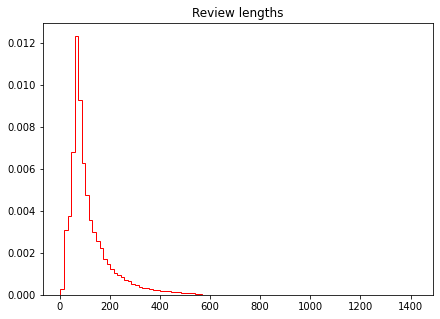

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
plt.hist(length, bins=100,density=1, histtype='step',color="r")
plt.title('Review lengths')
plt.show()

# Naive Bayes classifier

In [10]:
# get reviews column from df
reviews = data["review"]

# get labels column from df
labels = data["sentiment"]

In [13]:
# Use label encoder to encode labels. Convert to 0/1
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

# print(enc.classes_)
print(encoder.classes_)

['negative' 'positive']


In [14]:
# Split the data into train and test (80% - 20%). 
# Use stratify in train_test_split so that both train and test have similar ratio of positive and negative samples.
train_sentences, test_sentences, train_labels, test_labels = train_test_split(reviews, encoded_labels, test_size=0.2, random_state=123, stratify=labels)

Here there are two approaches possible for building vocabulary for the naive Bayes.
1. Take the whole data (train + test) to build the vocab. In this way while testing there is no word which will be out of vocabulary.
2. Take the train data to build vocab. In this case, some words from the test set may not be in vocab and hence one needs to perform smoothing so that one the probability term is not zero.
 
You are supposed to go by the 2nd approach.
 
Also building vocab by taking all words in the train set is memory intensive, hence you are required to build vocab by choosing the top 2000 - 3000 frequent words in the training corpus.

> $ P(x_i | w_j) = \frac{ N_{x_i,w_j}\, +\, \alpha }{ N_{w_j}\, +\, \alpha*d} $


$N_{x_i,w_j}$ : Number of times feature $x_i$ appears in samples of class $w_j$

$N_{w_j}$ : Total count of features in class $w_j$

$\alpha$ : Parameter for additive smoothing. Here consider $\alpha$ = 1

$d$ : Dimentionality of the feature vector  $x = [x_1,x_2,...,x_d]$. In our case its the vocab size.






In [15]:
train_df = pd.DataFrame({"train_sentences":train_sentences,"train_labels":train_labels},columns=["train_sentences","train_labels"])
train_df

,train_sentences,train_labels
29602,ive seen lot tv movi time student major normal...,1
45781,oscarwin short film minut base short stori wil...,1
13416,didnt writer movi see three love origin though...,0
46554,coupl week saw movi began remind john carpent ...,1
31434,watch malayalam movi boe boe made turn probabl...,0
...,...,...
25378,movi move much slowli tasteth concept stori re...,0
22032,two hand good addit australian film cataloguei...,1
40319,bob clampett hep cat distinct averag cartoon r...,0
28573,film brokedown palac direct jonathan kaplan tw...,1


In [16]:
from sklearn.feature_extraction.text import CountVectorizer
# Use Count vectorizer to get frequency of the words
from collections import Counter 
import random
def vocab(sentences,n=random.randint(2000,3001)):
  vectorizer = CountVectorizer(max_features = n)
  sents = vectorizer.fit_transform(sentences)
  return Counter(dict(zip(list(vectorizer.get_feature_names()), sents.sum(axis=0).A1))),n

In [17]:
train_sentences=train_sentences.to_numpy()
final_vocab,n = vocab(train_sentences)

In [18]:
def sentiment_corpus(sentences,labels,final_vocab=final_vocab):
  features_pos,features_neg={},{}
  n_pos,n_neg = 0,0
  for i in range(len(sentences)):
    words=sentences[i].split(' ')
    if labels[i] == 1:
      for word in words:
        if word in final_vocab:
          n_pos+=1
          if word in features_pos:
            features_pos[word]+=1
          else:
            features_pos[word]=1
    else:
      for word in words:
        if word in final_vocab:
          n_neg+=1
          if word in features_neg:
            features_neg[word]+=1
          else:
            features_neg[word]=1
  return features_pos,features_neg,n_pos,n_neg

In [19]:
features_pos,features_neg,n_pos,n_neg = sentiment_corpus(train_sentences,train_labels)

In [20]:
# Use laplace smoothing for words in test set not present in vocab of train set
def probability(word,sentiment,features_pos=features_pos,features_neg=features_neg,n_pos=n_pos,n_neg=n_neg,n=3000):
  prob=0
  if sentiment==1:
    if word in features_pos:
      prob=(features_pos[word]+1)/(n_pos+n)
    else:
      prob=1/(n_pos+n)
  else:
    if word in features_neg:
      prob=(features_neg[word]+1)/(n_neg+n)
    else:
      prob=1/(n_neg+n)
    
  return np.log(prob)  

In [21]:
# Build the model. Don't use the model from sklearn
def model(sentences):
  predictions=[]
  for sentence in sentences:
    words = sentence.split(' ')
    pos_prob=0
    neg_prob=0
    for word in words:
      pos_prob+= probability(word, 1)
      neg_prob+= probability(word, 0)
    
    predictions.append(1 if pos_prob>=neg_prob else 0)
  return predictions

In [22]:
prediction = model(test_sentences)

In [23]:
test_df = pd.DataFrame({"test_sentences":test_sentences,"test_labels":test_labels,"predictions":prediction},columns=["test_sentences","test_labels","predictions"])
test_df

,test_sentences,test_labels,predictions
16212,saw movi check rate imdb back thought wow must...,0,0
26046,ok admit watch movi mysteri scienc theater hug...,0,0
18424,charact unlik script aw wast talent deneuv aut...,0,0
2949,master director ching siu tung perhap popular ...,1,1
14913,probabl intend arti crime thriller fail count ...,0,0
...,...,...,...
13721,ive describ film surpris true mani respect sub...,1,1
2459,admit idea expect view high styliz piec could ...,1,1
20290,terribl disappoint citi men swept away citi go...,0,0
32939,man cant believ larg harsh negat comment movi ...,1,0


In [24]:
# Test the model on test set and report Accuracy
from sklearn.metrics import accuracy_score
print(classification_report(test_labels,prediction))
print("Accuracy of the Naive Bayer's Classification Model:",accuracy_score(prediction,test_labels)*100,"%")

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      5000
           1       0.83      0.84      0.84      5000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

Accuracy of the Naive Bayer's Classification Model: 83.7 %


# *LSTM* based Classifier

Use the above train and test splits.

In [25]:
# Hyperparameters of the model
vocab_size = 3000
oov_tok = '<OOK>'
embedding_dim = 100
max_length = 150 # choose based on statistics, for example 150 to 200
padding_type='post'
trunc_type='post'

In [26]:
# tokenize sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

# convert train dataset to sequence and pad sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)

# convert Test dataset to sequence and pad sequences
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

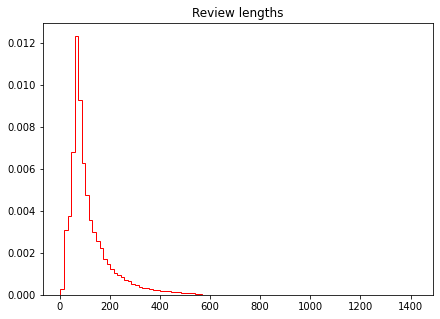

In [27]:
plt.figure(figsize=(7,5))
plt.hist(length, bins=100, density=1, histtype='step',color="r")
plt.title('Review lengths')
plt.show()

In [28]:
# model initialization
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 100)          300000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense (Dense)                (None, 24)                3096      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 387,601
Trainable params: 387,601
Non-trainable params: 0
_________________________________________________________________


In [29]:
num_epochs = 5
history = model.fit(train_padded, train_labels, 
                    epochs=num_epochs, verbose=1, 
                    validation_split=0.1)

Epoch 1/5
1125/1125 [==============================] - 98s 83ms/step - loss: 0.3873 - accuracy: 0.8271 - val_loss: 0.3131 - val_accuracy: 0.8692
Epoch 2/5
1125/1125 [==============================] - 90s 80ms/step - loss: 0.2884 - accuracy: 0.8834 - val_loss: 0.3135 - val_accuracy: 0.8673
Epoch 3/5
1125/1125 [==============================] - 90s 80ms/step - loss: 0.2556 - accuracy: 0.8970 - val_loss: 0.3285 - val_accuracy: 0.8610
Epoch 4/5
1125/1125 [==============================] - 90s 80ms/step - loss: 0.2183 - accuracy: 0.9147 - val_loss: 0.3479 - val_accuracy: 0.8605
Epoch 5/5
1125/1125 [==============================] - 89s 79ms/step - loss: 0.1847 - accuracy: 0.9301 - val_loss: 0.4045 - val_accuracy: 0.8635


In [30]:
# Calculate accuracy on Test data

prediction = model.predict(test_padded)

# Get probabilities
print(prediction)

predict=[]
# Get labels based on probability 1 if p>= 0.5 else 0
for i in prediction:
  if i>=0.5:
    predict.append(1)
  else:
    predict.append(0)

# Accuracy : one can use classification_report from sklearn
print(classification_report(test_labels,predict))
print("Accuracy of the LSTM :",accuracy_score(predict,test_labels)*100,"%")

[[0.06312712]
 [0.01015378]
 [0.01194079]
 ...
 [0.00137738]
 [0.1507678 ]
 [0.9860728 ]]
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      5000
           1       0.87      0.87      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Accuracy of the LSTM : 86.71 %


## Get predictions for random examples

In [32]:
# reviews on which we need to predict
sentence = ["The movie was very touching and heart whelming", 
            "I have never seen a terrible movie like this", 
            "the movie plot is terrible but it had good acting"]
processed_sentences=[]
for sent in sentence:
  processed_sentences.append(pre_processing(sent))
# convert to a sequence
sequences = tokenizer.texts_to_sequences(processed_sentences)

# pad the sequence
padded =  pad_sequences(sequences, padding='post', maxlen=max_length)

# Get probabilities

predict = model.predict(padded)
test_sent_prob=[]
# Get labels based on probability 1 if p>= 0.5 else 0
for i in predict:
  if i>=0.5:
    test_sent_prob.append(1)
  else:
    test_sent_prob.append(0)
count=0
for sent in sentence: 
  print(sent,":","Positive Review with a probability" if test_sent_prob[count]==1 else "Negative Review with a probability",end=" ")
  print(predict[count][0])
  count+=1
print("-"*100)

count=0
print("\nFinal Predictions\n")
for sent in sentence: 
  print(sent,":","Positive Review" if test_sent_prob[count]==1 else "Negative Review")
  count+=1
print("-"*100)

The movie was very touching and heart whelming : Positive Review with a probability 0.8453154
I have never seen a terrible movie like this : Negative Review with a probability 0.15641141
the movie plot is terrible but it had good acting : Negative Review with a probability 0.0655057
----------------------------------------------------------------------------------------------------

Final Predictions

The movie was very touching and heart whelming : Positive Review
I have never seen a terrible movie like this : Negative Review
the movie plot is terrible but it had good acting : Negative Review
----------------------------------------------------------------------------------------------------
